In [2]:
#only run this to mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import numpy as np
from sklearn.utils import shuffle

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: GPU device not found

In [19]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/datasets/allHousesFilled.csv')
df.head()

,HouseNum,TimeSin,TimeCos,DayNumSin,DayNumCos,MonthSin,MonthCos,RealTemp,ApparTemp,Humid,...,Type_END OF TERRACE,Type_FLAT,Type_SEMI-DETACHED,Type_MID-TERRACE,NumRooms,NumOccupants,Total,AlwaysOn,Intermit,HVAC
0,1.0,-0.500000,-8.660254e-01,0.974928,-0.222521,-0.866025,0.5,0.792136,0.392199,0.59,...,0.0,0.0,0.0,0.0,0.4,0.2,5.489313,0.041201,0.001036,0.957763
1,1.0,-0.707107,-7.071068e-01,0.974928,-0.222521,-0.866025,0.5,0.607125,0.255182,0.65,...,0.0,0.0,0.0,0.0,0.4,0.2,5.301124,0.095364,0.001536,0.903100
2,1.0,-0.866025,-5.000000e-01,0.974928,-0.222521,-0.866025,0.5,0.311106,0.011597,0.70,...,0.0,0.0,0.0,0.0,0.4,0.2,5.240370,0.152939,0.001684,0.845377
3,1.0,-0.965926,-2.588190e-01,0.974928,-0.222521,-0.866025,0.5,0.144596,-0.186317,0.66,...,0.0,0.0,0.0,0.0,0.4,0.2,4.759992,0.097266,0.003417,0.899317
4,1.0,-1.000000,-1.836970e-16,0.974928,-0.222521,-0.866025,0.5,0.015088,-0.384230,0.62,...,0.0,0.0,0.0,0.0,0.4,0.2,4.791903,0.296886,0.100860,0.602254


In [20]:
# Metadata for the windowing and network
num_device_categories = 3
num_input_parameters = 46
num_recur_hours = 24

In [ ]:
# # Only run this to recreate windows
# # This creates a windowing function
# def create_sequential_windows(group, window_size):
#     # Check to see if there is enough data
#     if group.shape[0] < window_size:
#         return None

#     windows = []
#     start_index = 0
#     while start_index + window_size <= group.shape[0]:
#         window = group.iloc[start_index:start_index + window_size].copy()
#         windows.append(window)
#         start_index += 1

#     return windows

# # Apply the windowing function
# sequential_windows = df.groupby('HouseNum').apply(lambda x: create_sequential_windows(x.drop(columns=['HouseNum']), num_recur_hours))
# all_windows = [window for sublist in sequential_windows if sublist is not None for window in sublist]

# # Shuffle the windows
# all_windows = shuffle(all_windows)
# if all_windows:
#     windows_array = np.array([window.values for window in all_windows])

#     # Print the shape for confirmation
#     print("Shape of the array:", windows_array.shape)

#     # Convert to a TensorFlow tensor
#     windows_tensor = tf.convert_to_tensor(windows_array, dtype=tf.float32)

#     # Print the shape of the tensor
#     print("Shape of the tensor:", windows_tensor.shape)
# else:
#     print("No windows were created.")

# # Save the windowed data
# np.save('/content/drive/MyDrive/datasets/CreatedWindows.npy', windows_array)

In [21]:
windows_array = np.load('/content/drive/MyDrive/datasets/CreatedWindows.npy')

In [22]:
checkpoint_path = "/content/drive/MyDrive/datasets/training_1/cp-{epoch:04d}.ckpt"

# Making a callback to save model weights every epoch
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')


In [23]:
# Two layer LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(num_recur_hours, (num_input_parameters-num_device_categories))),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(num_device_categories, activation='softmax')
])

# Adam optimizer, crossentropy loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 24, 100)           57600     
                                                                 
 dropout_4 (Dropout)         (None, 24, 100)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 87953 (343.57 KB)
Trainable params: 87953 (343.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
from sklearn.model_selection import train_test_split


selected_features_tensor = windows_array[:, -1:, -3:]
selected_features_tensor = np.array([np.squeeze(arr) for arr in selected_features_tensor])
training_features_tensor = windows_array[:, :, :-3]

print("Number of samples in selected_features_tensor:", len(selected_features_tensor))
print("Number of samples in training_features_tensor:", training_features_tensor.shape[0])

X_train, X_test, y_train, y_test = train_test_split(training_features_tensor, selected_features_tensor, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)



Number of samples in selected_features_tensor: 247313
Number of samples in training_features_tensor: 247313
(197850, 24, 43)
(197850, 3)


In [26]:
checkpoint_dir =  '/content/drive/MyDrive/datasets/training_1/'
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
if latest_checkpoint:
    # Load both the model and the optimizer state
    model.load_weights(latest_checkpoint)
    print("Model restored from checkpoint: {}".format(latest_checkpoint))
    # Extract the last epoch number from the checkpoint filename if needed
    import re
    last_epoch = int(re.search(r'cp-(\d{4}).ckpt', latest_checkpoint).group(1))
else:
    print("No checkpoint found. Initializing model from scratch.")
    last_epoch = 0

print('Starting from epoch ' + str(last_epoch))


Model restored from checkpoint: /content/drive/MyDrive/datasets/training_1/cp-0040.ckpt
Starting from epoch 40


In [27]:
LSTM = model.fit(X_train, y_train, epochs=40, initial_epoch=last_epoch, batch_size=32, verbose=1, callbacks=[cp_callback], validation_split=0.2)

In [ ]:
model.save('/content/drive/MyDrive/datasets/training_1/finalModel', save_format='tf')

1546/1546 [==============================] - 22s 14ms/step
Accuracy: 0.8968926268119605
Precision: 0.8903936527419852
Recall: 0.8968926268119605
F1 Score: 0.8874343947483707


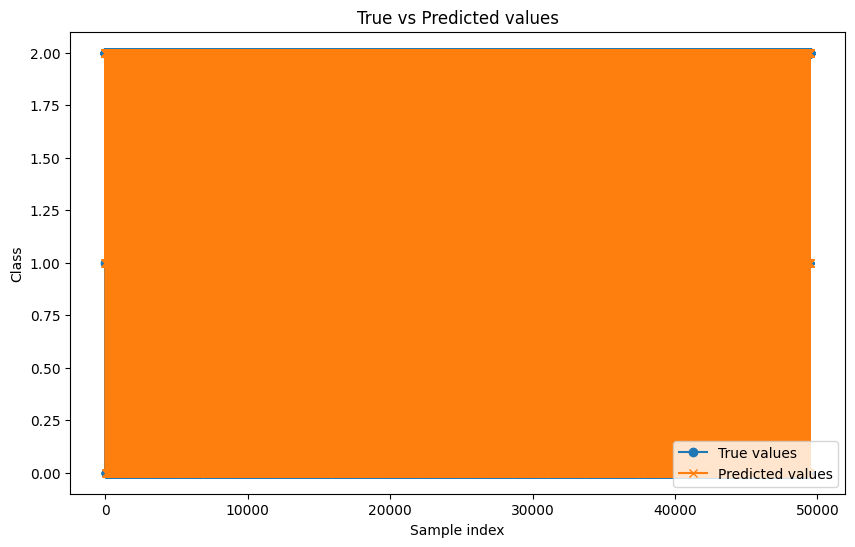

In [32]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import zipfile
import os


# Load the saved model
model = load_model('/content/drive/MyDrive/datasets/training_1/finalModel')

# Make predictions on the test data
predictions = model.predict(X_test)


In [39]:

# for softmax convert predictions back to labels
y_pred = predictions
predicted_labels = np.argmax(predictions, axis=1)

# You can calculate different performance metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), predicted_labels)
precision = precision_score(np.argmax(y_test, axis=1), predicted_labels, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), predicted_labels, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), predicted_labels, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)




Accuracy: 0.8968926268119605
Precision: 0.8903936527419852
Recall: 0.8968926268119605
F1 Score: 0.8874343947483707


In [40]:
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PowerTransformer
import numpy as np
import pandas as pd

def inverse_yeo_johnson(y, lambda_):
    if lambda_ == 0:
        return np.exp(y) - 1
    else:
        if y >= 0:
            return (y * lambda_ + 1) ** (1 / lambda_) - 1
        else:
            return -((1 - y * (2 - lambda_)) ** (1 / (2 - lambda_)) - 1)


# must be passed in as a Dataframe
# total_energy_inverseYeoJohnson is the transformed values |
# total_energy_actual is the real values for energy
def calculate_total_inverse_yeo_johnson(total_df, lambda_value=-0.06419593996677918):
    if 'Total' in total_df.columns:
        total_energy_inverseYeoJohnson = pd.DataFrame(total_df['Total'])
        total_energy_actual = total_energy_inverseYeoJohnson.apply(lambda row: inverse_yeo_johnson(row['Total'], lambda_value), axis=1)
        total_energy_actual_df = pd.DataFrame(total_energy_actual, columns=['Total'])
        total_energy_actual_array = total_energy_actual.values.flatten()

        print("Original total values, [Total]:\n", total_energy_inverseYeoJohnson.sort_index().head(3))
        print("coverted total energy test data\n", total_energy_actual_df.sort_index().head(3))

        return total_energy_actual, total_energy_actual_df, total_energy_actual_array
    else:
        print("No 'Total' column found in the DataFrame.")
        return None, None, None




def convert_fractions_to_actuals(fractions, total_energy_actual_array, columns_to_apply=['AlwaysOn', 'Intermit', 'HVAC']):
    # Check if the required columns exist in fractions DataFrame
    if isinstance(fractions, pd.DataFrame):
        valid_columns = [col for col in columns_to_apply if col in fractions.columns]
    else:
        valid_columns = columns_to_apply
        print("valid_columns",valid_columns)

    # If the required columns exist, apply the conversion
    if valid_columns:
        fractions_array = fractions[valid_columns].values if isinstance(fractions, pd.DataFrame) else fractions
        fractions_actuals = fractions_array * total_energy_actual_array[:, np.newaxis]
        if isinstance(fractions, pd.DataFrame):
            fractions_actuals_df = pd.DataFrame(fractions_actuals, index=fractions.index, columns=valid_columns)
            print("Result: fractions_actuals_df\n", fractions_actuals_df.sort_index().head(3))
        else:
            print("Result: fractions_actuals\n", fractions_actuals[:3])
        return fractions_actuals, fractions_actuals_df if isinstance(fractions, pd.DataFrame) else None
    else:
        print("No valid columns found for conversion in ['AlwaysOn', 'Intermit', 'HVAC']")
        return None, None

In [41]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# #make sure you convert to the same values
def calculate_performance_metrics(y_test_actuals, y_pred_actuals_model, y_test_fracs=None, y_pred_fracs_model=None):
    # Calculate performance metrics
    metrics = {}

    metrics['mse'] = mean_squared_error(y_test_actuals, y_pred_actuals_model, multioutput='raw_values')
    metrics['rmse'] = np.sqrt(metrics['mse'])
    metrics['mae'] = mean_absolute_error(y_test_actuals, y_pred_actuals_model, multioutput='raw_values')
    metrics['mape'] = mean_absolute_percentage_error(y_test_actuals, y_pred_actuals_model, multioutput='raw_values')
    metrics['r2'] = r2_score(y_test_actuals, y_pred_actuals_model, multioutput='raw_values')

    # Calculate differences and absolute differences
    differences = y_pred_actuals_model - y_test_actuals
    absolute_differences = np.abs(differences)

    # Calculate additional metrics
    metrics['max_difference'] = np.max(differences, axis=0)
    metrics['mean_difference'] = np.mean(differences, axis=0)
    metrics['median_difference'] = np.median(differences, axis=0)
    metrics['mean_absolute_difference'] = np.mean(absolute_differences, axis=0)
    metrics['median_absolute_difference'] = np.median(absolute_differences, axis=0)


    if y_test_fracs is not None and y_pred_fracs_model is not None:
        # Now doing it in fractions
        absolute_differences_fracs = np.abs(y_test_fracs - y_pred_fracs_model)
        metrics['mean_absolute_difference_fracs'] = np.mean(absolute_differences_fracs, axis=0)
        metrics['max_absolute_difference_fracs'] = np.max(absolute_differences_fracs, axis=0)

    # Check if any of the predicted values are negative
    negative_values = y_pred_actuals_model < 0
    num_negative_values = np.sum(negative_values)
    if num_negative_values > 0:
        print(f"Warning!!: {num_negative_values} predicted values are negative")
    return metrics

def print_performance_metrics(metrics):
    print("Y.head: ", Y.columns.to_list())
    print("MSE per output:", metrics['mse'])
    print("RMSE per output:", metrics['rmse'])
    print("MAE per output:", metrics['mae'])
    print("MAPE per output:", metrics['mape'])
    print("R^2 per output:", metrics['r2'])
    print("Maximum Difference:", metrics['max_difference'])
    print("Mean Difference:", metrics['mean_difference'])
    print("Median Difference:", metrics['median_difference'])
    print("Mean Absolute Difference:", metrics['mean_absolute_difference'])
    print("Median Absolute Difference:", metrics['median_absolute_difference'])

    if 'mean_absolute_difference_fracs' in metrics:
        print("Mean Absolute Difference in percentage(%): ", metrics['mean_absolute_difference_fracs'])
        print("Maximum Absolute Difference in percentage(%): ", metrics['max_absolute_difference_fracs'])


In [116]:
import matplotlib.pyplot as plt

def histogram_residuals(y_test_actuals, y_pred_actuals_model):
    columns = ['AlwaysOn', 'Intermit', 'HVAC']

    y_test_actuals_df = pd.DataFrame(y_test_actuals, columns=columns)
    y_pred_actuals_model_df = pd.DataFrame(y_pred_actuals_model, columns=columns)

    # Calculate residuals
    residuals = y_test_actuals_df - y_pred_actuals_model_df

    # calculate range based on the data, ignoring the extreme x% of values
    # adjust this based on the range, just so we can see the results better
    lower_percentile = residuals.quantile(0.05)#0.00
    upper_percentile = residuals.quantile(0.95)

    # Plot histogram of residuals for each target variable
    for column in residuals.columns:
        current_residuals = residuals[column]

        range_min = lower_percentile[column]
        range_max = upper_percentile[column]

        # Create histogram of residuals
        plt.figure(figsize=(8, 6))
        plt.hist(current_residuals, bins=100, range=(range_min, range_max)) # range=(-1000, 1000)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title(f'LSTM Histogram of Residuals - {column}')
        plt.show()

In [108]:
column_names = list(df.columns[1:-3])
X_test_copy = X_test[:, -1, :]
X_test_copy
X_test_df = pd.DataFrame(X_test_copy, columns=column_names)


In [110]:
y_column_names = list(df.columns[-3:])

y_test_df = pd.DataFrame(y_test, columns=y_column_names)

In [111]:
total_energy_actual, total_energy_actual_df, total_energy_actual_array = calculate_total_inverse_yeo_johnson(X_test_df)
y_test_actuals, y_test_actuals_df = convert_fractions_to_actuals(y_test_df, total_energy_actual_array)
y_pred_actuals, y_test_actuals_df = convert_fractions_to_actuals(y_pred, total_energy_actual_array)
calculate_performance_metrics(y_test_actuals, y_pred_actuals)


Original total values, [Total]:
       Total
0  5.340162
1  5.729140
2  4.895691
coverted total energy test data
       Total
0   690.757
1  1263.788
2   355.801
Result: fractions_actuals_df
    AlwaysOn  Intermit      HVAC
0    59.310    91.427   540.020
1    55.758     9.018  1199.012
2    36.644    47.579   271.578
valid_columns ['AlwaysOn', 'Intermit', 'HVAC']
Result: fractions_actuals
 [[  31.14041314  187.32905851  472.2875824 ]
 [  36.44228094   25.7172806  1201.6283137 ]
 [  36.44107029   67.28620961  252.07369359]]


{'mse': array([  823.68886987, 10685.58441808, 10937.54970803]),
 'rmse': array([ 28.69998031, 103.3711005 , 104.58274097]),
 'mae': array([16.36962661, 42.1411893 , 46.12332225]),
 'mape': array([1.72182688e+15, 3.30618797e+15, 1.11042861e+13]),
 'r2': array([0.73981177, 0.85418092, 0.92201142]),
 'max_difference': array([ 674.66837662, 2329.61558028, 1532.81977067]),
 'mean_difference': array([ 1.2674197 , -2.66571063,  1.39828378]),
 'median_difference': array([1.28646807, 0.55610565, 0.96946082]),
 'mean_absolute_difference': array([16.36962661, 42.1411893 , 46.12332225]),
 'median_absolute_difference': array([10.28328943, 11.03258582, 17.29998964])}

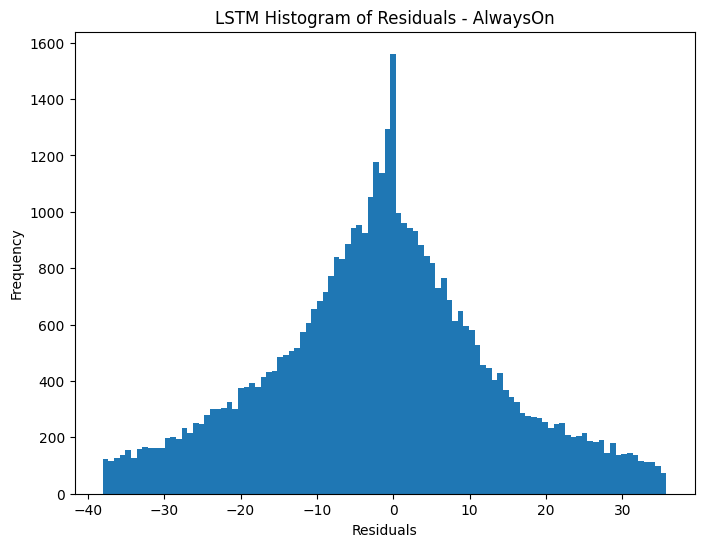

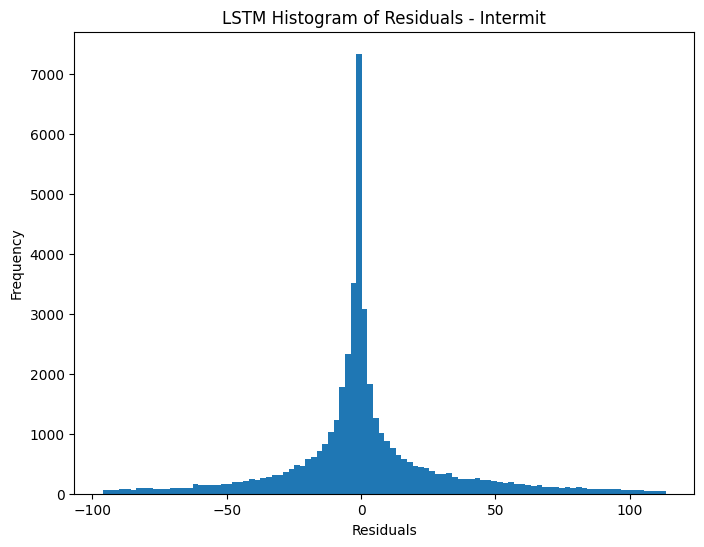

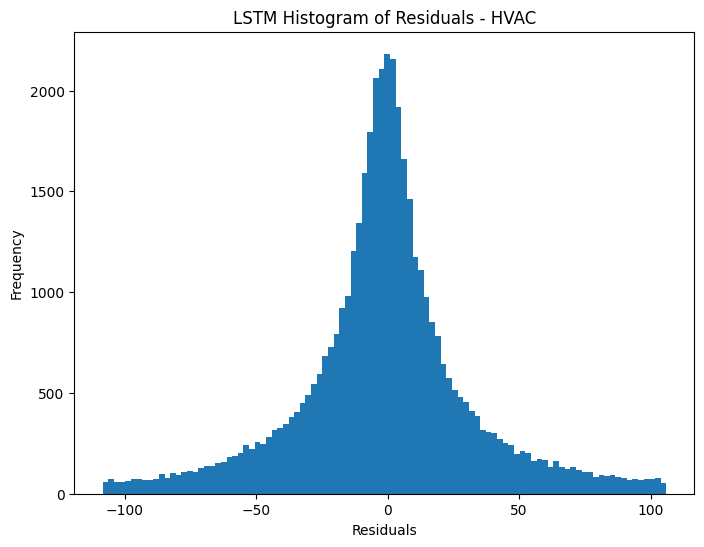

In [117]:
histogram_residuals(y_test_actuals, y_pred_actuals)